# Plastic Thermal Oxidation Example
This page runs a process model for the thermal oxidation of plastics using Biosteam. 

Click on the menu Runtime-> Run All to run the complete analysis or press shift+enter on each cell.

In [1]:
# Some required programs
# !pip install biosteam &> /dev/null
# !pip install llvmlite --upgrade &> /dev/null

In [2]:
import biosteam as bst
from biosteam import units
from chemicals.identifiers import CAS_from_any, search_chemical

from reactor import Reactor
from cyclone import Cyclone
from ryield import RYield
from compounds import *
import utilities
from tea import PyrolysisTEA

# Key Assumptions
## Plastic Composition

In [3]:
x_PET = 0.06 #@param {type: "number"}
x_PE = 0.80 #@param {type: "number"}
x_PP = 0.13 #@param {type: "number"}
x_Al = 1 - x_PET - x_PE - x_PP

plastic_composition = dict(PET = x_PET, 
                          PE = x_PE, 
                          PP = x_PP, 
                          Al = x_Al)

## Pyrolysis Yields


In [4]:
# ToDo: Model pyrolysis yields as a function of plastic composition, operating
# conditions, and catalyst
pyrolysis_yields = dict(CO2 = 0.05,
                        Benzene=0.468,
                        Heptane=0.13,
                        Heptene=0.16,
                        Water=0.02)



# Process Analysis

In [5]:
# Raw material prices (USD/kg)
prices = {'Plastic': -55.36/1000,
         'Water': 0, # 0.000353,
         'Polymer': 0, # Not significant
         'Steam': 0, # 0.017,
         'Metals': 330/1000,
         'Aromatics': 665/1000,
         'Olefins': 600/1000,
         'Solids': 20/1000} # 

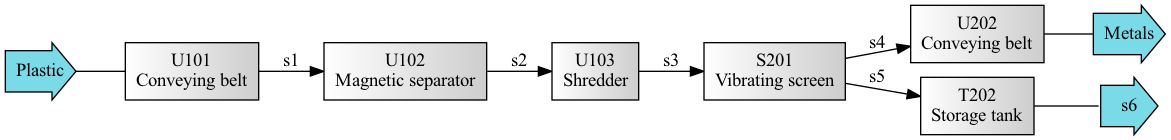

System: pretreatment
ins...
[0] Plastic
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): C10H10O4  2.57
                    C22H42O3  3.06
                    C2H4      238
                    Al        3.09
outs...
[0] s6
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] Metals
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [6]:
bst.main_flowsheet.set_flowsheet('pretreatment')

z_mass_plastic = chemicals.kwarray(
    plastic_composition
)

plastic = bst.Stream('Plastic',
                       flow=200000 * z_mass_plastic,
                       units='kg/day',
                       price=prices['Plastic'])

u101 = units.ConveyingBelt('U101', ins=plastic)
# Separatate metals
u102 = units.MagneticSeparator('U102', ins=u101-0)
# Shredder
u103 = units.Shredder('U103', ins=u102-0)

# u201 = units.CrushingMill('U201', split=dict(PET=0.9, PE=0.9, PP=0.9, Al=0.1), moisture_content=0)

# Screen out fibers
s201 = units.VibratingScreen('S201', ins=u103-0,
                             split=dict(PET=0.01, PE=0.01, PP=0.01, Al=0.99), outs=('', ''))

waste = bst.Stream('Metals', price=prices["Metals"])
u202 = units.ConveyingBelt('U202', ins=s201-0, outs=waste)

# Store juice before treatment
t202 = units.StorageTank('T202', tau=4, vessel_material='Carbon steel', ins=s201-1)


# plastic-u101-u103-S201-0-T202
# S201-1-u202

pretreatment_sys = bst.main_flowsheet.create_system('pretreatment')

pretreatment_sys.diagram('thorough')
pretreatment_sys.show()

In [7]:
bst.main_flowsheet.set_flowsheet('conversion')

c101 = Reactor('Pyrolysis_TDP', ins=t202-0, yields=chemicals.kwarray(
    pyrolysis_yields
    ))


c102 = Cyclone('C102', ins=c101-0, outs=('', 'SolidWaste'), efficiency=0.99)

conversion_sys = bst.main_flowsheet.create_system('conversion')
conversion_sys.diagram('thorough')
conversion_sys.show()

System: conversion
ins...
outs...


/Users/mark/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: RuntimeWarning: undocked inlet stream s8 from unit r101; s8 is now docked at r101
  """


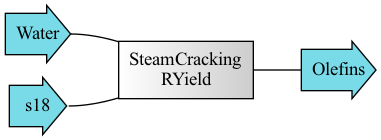

System: recovery
ins...
[0] Water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
outs...
[0] Olefins
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


In [9]:
bst.main_flowsheet.set_flowsheet('recovery')

# bst.settings.set_thermo((c102-0).chemicals)

r101 = units.HXutility('r101', ins=c102-0, outs=(), T=120+273.15, rigorous=False)

r102 = units.Splitter('r102', ins=r101-0, outs=('', ''), split={"Water":0.99, "CO2":1.0, "Benzene":1.0})
r103 = units.Flash('r103', ins=r102-0, outs=('NCG', ''), T=30+273.15, P = 101325)

aromatics = bst.Stream('Aromatics', price=prices["Aromatics"])
r104 = units.LLEUnit('r104', ins=r103-1, outs=(aromatics, 'Wastewater'))

r105 = units.Splitter('r105', ins=r102-1, outs=('Alkanes', ''), split={"C7H14":1.0})

olefins = bst.Stream('Olefins', price=prices["Olefins"])
water = bst.Stream('Water', Water=(r105-1).F_mol)
r106 = RYield('SteamCracking', ins=(r105-1, water), outs=(olefins), yields =chemicals.kwarray({"C7H14":1.0}))

recovery_sys = bst.main_flowsheet.create_system('recovery')
recovery_sys.diagram('thorough')
recovery_sys.show()


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/biosteam/units/design_tools/pressure_vessel.py:79: CostWarning: <Flash: r103> Vertical vessel weight (548.4 lb) is out of bounds (4200 to 1e+06 lb).
  return method(pressure, diameter, length)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/biosteam/units/design_tools/pressure_vessel.py:79: CostWarning: <Flash: r103> Vertical vessel length (5.5 ft) is out of bounds (12 to 40 ft).
  return method(pressure, diameter, length)
sys:1: DesignWarning: <ConveyingBelt: U202> Flow rate (5.827 kg/hr) is out of bounds (minimum 3 kg/hr).


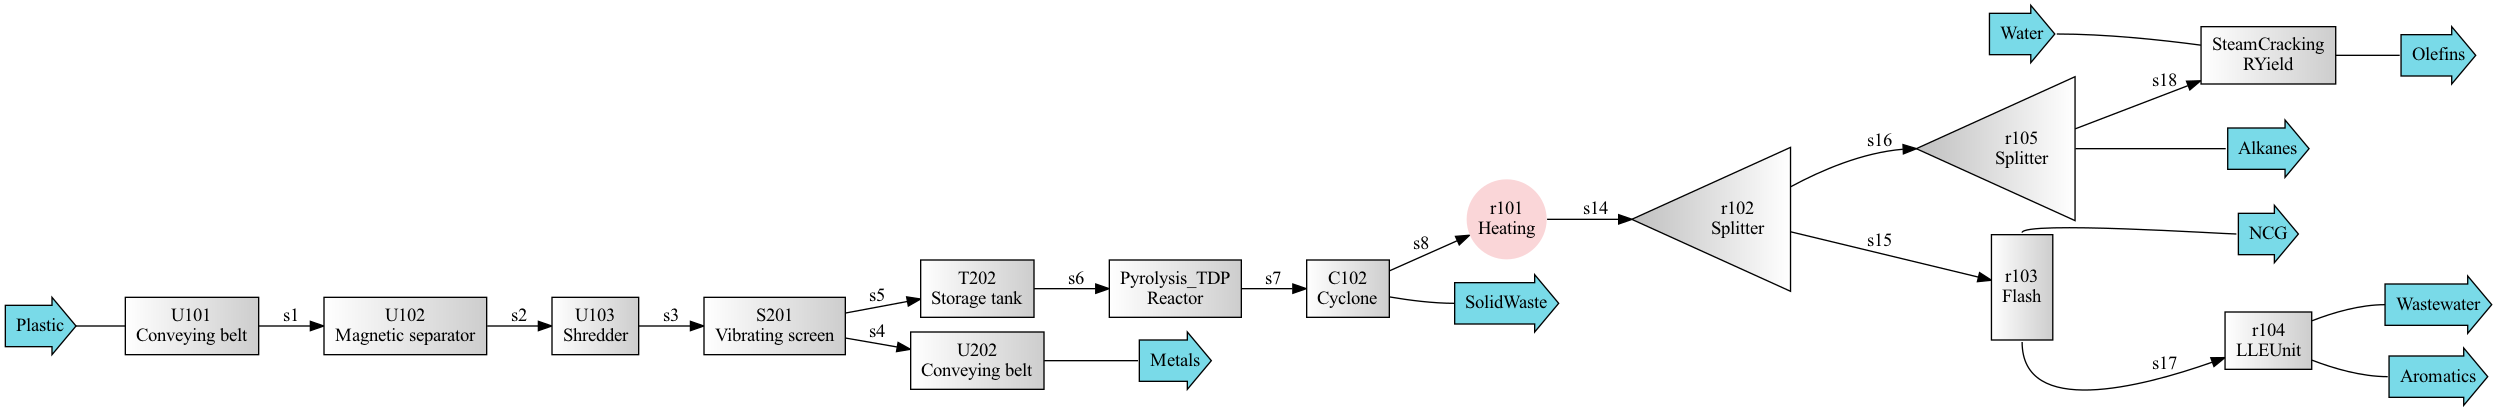

System: facility_sys
ins...
[0] Plastic
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): C10H10O4  2.57
                    C22H42O3  3.06
                    C2H4      238
                    Al        3.09
[1] Water
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
outs...
[0] SolidWaste
    phase: 's', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] NCG
    phase: 'g', T: 303.15 K, P: 101325 Pa
    flow (kmol/hr): Water    2.54
                    CO2      9.28
                    Benzene  48.9
[2] Aromatics
    phase: 'l', T: 303.15 K, P: 101325 Pa
    flow (kmol/hr): Water    0.000166
                    Benzene  0.0149
[3] Wastewater
    phase: 'l', T: 303.15 K, P: 101325 Pa
    flow (kmol/hr): Water    6.44
                    Benzene  0.00309
[4] Alkanes
    phase: 'g', T: 393.15 K, P: 101325 Pa
    flow (kmol/hr): C7H14  13.3
[5] Metals
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): C10H10O4  0.0257
                    C22H42O3  0.0306
               

In [10]:
facility_flowsheet = bst.main_flowsheet.from_flowsheets('facility_flowsheet', 
    ['pretreatment', 'conversion', 'recovery']
)

facility_sys = facility_flowsheet.create_system('facility_sys')  
facility_sys.simulate() 
facility_sys.diagram('thorough')  
facility_sys.diagram(file="plastics_pyrolysis")
facility_sys.show() 

# Techno-economic analysis

In [15]:
pyrolysis_tea = PyrolysisTEA(system=facility_sys,
                             IRR=0.10,
                             duration=(2018, 2038),
                             depreciation='MACRS7',
                             income_tax=0.35,
                             operating_days=330,
                             lang_factor=3.73,
                             construction_schedule=(0.08, 0.6, 0.32),
                             WC_over_FCI=0.05,
                             labor_cost=2.12e6,
                             fringe_benefits=0.4,
                             property_tax=0.001,
                             property_insurance=0.005,
                             supplies=0.20,
                             maintenance=0.01,
                             administration=0.005)

# pyrolysis_tea.IRR = pyrolysis_tea.solve_IRR()
pyrolysis_tea.show()

PyrolysisTEA: facility_sys
 NPV: -86,021,027 USD at 10.0% IRR


In [12]:
m = pyrolysis_tea.get_cashflow_table()
m

,Depreciable capital [MM$],Fixed capital investment [MM$],Working capital [MM$],Depreciation [MM$],Loan [MM$],...,Net earnings [MM$],Cash flow [MM$],Discount factor,Net present value (NPV) [MM$],Cumulative NPV [MM$]
2015,8.13,8.13,0,0,0,...,0,-8.13,1.21,-9.83,-9.83
2016,60.9,60.9,0,0,0,...,0,-60.9,1.1,-67,-76.9
2017,32.5,32.5,5.08,0,0,...,0,-37.6,1,-37.6,-114
2018,0,0,0,14.5,0,...,-10.8,3.74,0.909,3.4,-111
2019,0,0,0,24.9,0,...,-21.1,3.74,0.826,3.09,-108
2020,0,0,0,17.8,0,...,-14,3.74,0.751,2.81,-105
2021,0,0,0,12.7,0,...,-8.95,3.74,0.683,2.55,-103
2022,0,0,0,9.07,0,...,-5.33,3.74,0.621,2.32,-100
2023,0,0,0,9.06,0,...,-5.32,3.74,0.564,2.11,-98.2
2024,0,0,0,9.07,0,...,-5.33,3.74,0.513,1.92,-96.2


In [23]:
products = [bst.main_flowsheet("Plastic"), bst.main_flowsheet('Aromatics'), bst.main_flowsheet('Olefins'), bst.main_flowsheet('Metals')]
pyrolysis_tea.solve_price(bst.main_flowsheet('Aromatics'))

1372.8341467458554